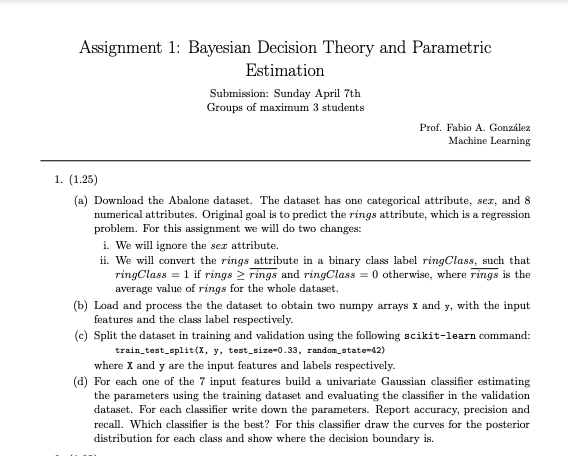

In [2]:
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo 
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. a);b);c) #

In [3]:
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# load data into df
X = abalone.data.features 
y = abalone.data.targets 

#dont use sex feature
X_sexless = X.drop(columns=['Sex'])

#class rings from target
average_y = y['Rings'].mean()
classRings = y['Rings'].apply(lambda x: 1 if x >= average_y else 0)

# split data
X_train,X_test,y_train,y_test=train_test_split(X_sexless,classRings, test_size=0.33, random_state=42)

# 1. d)

In [4]:
# use a gaussian for each variable
report_table = pd.DataFrame(columns=['variable', 'mean', 'var', 'accuracy','precision','recall'])

for variable in X_train.columns:
    gnb = GaussianNB()
    y_pred = gnb.fit(X_train[[variable]].values, y_train).predict(X_test[[variable]].values)
    # print(gnb.theta_)
    # print(gnb.var_)
    accuracy = (y_test == y_pred).sum()/X_test.shape[0] #porcentaje de aciertos
    #verdaderos positivos
    vp = np.sum((y_test == 1) & (y_pred == 1))
    precision = vp/ y_pred.sum() #verdaderos positivos sobre predichos positivos
    recall = vp/ y_test.sum() #verdaderos positivos  sobre positivos
    report_table = pd.concat([report_table, pd.DataFrame({'variable': variable, 'mean':gnb.theta_[0], 'var': gnb.var_[0], 'accuracy': accuracy, 'precision': precision, 'recall': recall}, index=[0])], ignore_index=True)

report_table

,variable,mean,var,accuracy,precision,recall
0,Length,0.463943,0.013969,0.708484,0.662211,0.814649
1,Diameter,0.356865,0.009369,0.726613,0.680247,0.823617
2,Height,0.119095,0.001950,0.744017,0.695545,0.840060
3,Whole_weight,0.574403,0.146426,0.727339,0.739771,0.675635
4,Shucked_weight,0.262761,0.034090,0.674402,0.691638,0.593423
5,Viscera_weight,0.125555,0.007523,0.708484,0.730570,0.632287
6,Shell_weight,0.160143,0.010163,0.759971,0.775244,0.711510


In [5]:
def root(mu0,mu1,var0,var1):
    a = var0-var1
    b = 2*(mu0*var1 - mu1*var0)
    c = var0*mu1**2 - var1*mu0**2 - 2*(var0*var1)*np.log(np.sqrt(var0/var1))
    return np.roots([a,b,c])


decision boundary: 0.24982986416951422


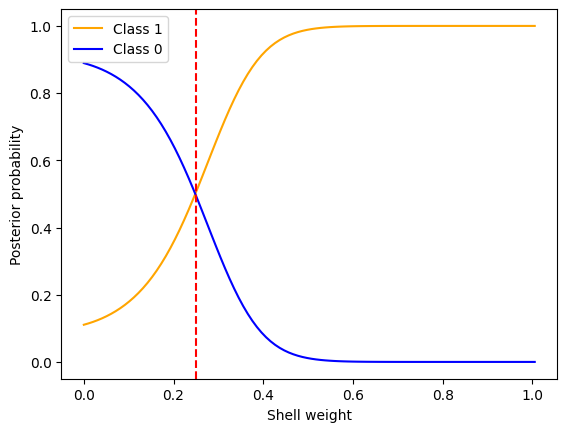

In [6]:
# Shell weight classifier is the best (no hay preferencia de falsos negativos sobre falsos positivos, solo importan los aciertos???)
gnbBest = GaussianNB()
y_pred = gnbBest.fit(X_train[['Shell_weight']].values, y_train)
x_plot = np.linspace(0,X_sexless.Shell_weight.max(),100)
probabilities = gnbBest.predict_proba(x_plot.reshape(-1, 1))

# convert theta and var to rank-1 arrays
theta = gnbBest.theta_.flatten()
var = gnbBest.var_.flatten()

a,b=  root(theta[0], theta[1], var[0], var[1])
print('decision boundary:',b)
plt.plot(x_plot,probabilities[:, 1], color='orange',label='Class 1');
plt.plot(x_plot,probabilities[:, 0], color='blue',label='Class 0');
plt.xlabel('Shell weight')
plt.axvline(x=b, color='red', linestyle='--');
plt.ylabel('Posterior probability')
plt.legend();


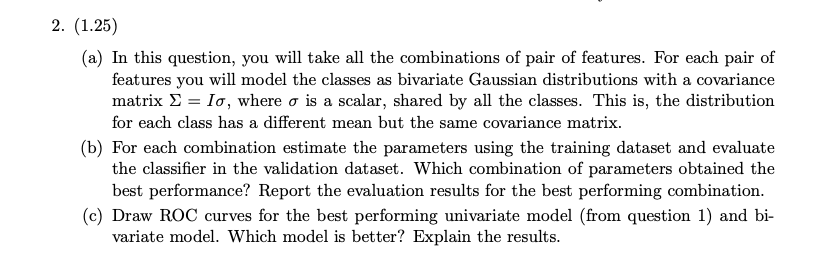

# 2.

In [7]:

def sigma_mle(vec):
    pos =  vec[0]/2+np.sqrt(vec[0]/4+4*(vec[1]**2-vec[1]*vec[0]))/2*(1-vec[1]/vec[0])
    neg =  vec[0]/2-np.sqrt(vec[0]/4+4*(vec[1]**2-vec[1]*vec[0]))/2*(1-vec[1]/vec[0]) 
    if pos>0:
        return pos
    elif neg>0:
        return neg
    else:
        return 0
class GaussianNBConst(GaussianNB):
    def _partial_fit(self, X, y, classes=None, _refit=False,sample_weight=None):
        # Add your custom implementation here
        # ...
        # Call the parent class's _partial_fit function
        super()._partial_fit(X, y,classes)
        variance_matrix = self.var_
        variances_vector =variance_matrix.sum(axis=1)
        sigma = sigma_mle(variances_vector)
        unique_variance = np.array([1,1])*sigma
        self.var_ = np.array([unique_variance,unique_variance])
        self.var_[:, :] += self.epsilon_

        # Update if only no priors is provided
        if self.priors is None:
            # Empirical prior, with sample_weight taken into account
            self.class_prior_ = self.class_count_ / self.class_count_.sum()

        return self


In [117]:
import itertools

gnbCustom = GaussianNBConst()
# Get the column names of X
column_names = X_train.columns

# Create all possible pairs of features
feature_pairs = list(itertools.combinations(column_names, 2))
report_table = pd.DataFrame(columns=['variable0','variable1', 'mean', 'sigma', 'accuracy','precision','recall'])

# Print the feature pairs
for pair in feature_pairs:
    gnbCustom = GaussianNBConst()
    y_pred = gnbCustom.fit(X_train[list(pair)].values, y_train).predict(X_test[list(pair)].values)
    # print(gnb.theta_)
    # print(gnb.var_)
    accuracy = (y_test == y_pred).sum()/X_test.shape[0]
    #verdaderos positivos
    vp = np.sum((y_test == 1) & (y_pred == 1))
    precision = vp/ y_pred.sum() #verdaderos positivos sobre predichos positivos
    recall = vp/ y_test.sum() #verdaderos positivos sobre positivos
    F1 = 2*(precision*recall)/(precision+recall)
    report_table = pd.concat([report_table, pd.DataFrame({'variable0': pair[0],'variable1':pair[1], 'mean':str(gnb.theta_[0]), 'sigma':str(gnb.var_[0][0]), 'accuracy': accuracy, 'precision': precision, 'recall': recall,'F1':F1}, index=[0])], ignore_index=True)

report_table

,variable0,variable1,mean,sigma,accuracy,precision,recall,F1
0,Length,Diameter,[0.16014322],0.01016307961668813,0.719362,0.687003,0.774290,0.728039
1,Length,Height,[0.16014322],0.01016307961668813,0.721537,0.690763,0.771300,0.728814
2,Length,Whole_weight,[0.16014322],0.01016307961668813,0.727339,0.727838,0.699552,0.713415
3,Length,Shucked_weight,[0.16014322],0.01016307961668813,0.694706,0.690184,0.672646,0.681302
4,Length,Viscera_weight,[0.16014322],0.01016307961668813,0.718637,0.702158,0.729447,0.715543
5,Length,Shell_weight,[0.16014322],0.01016307961668813,0.737491,0.722142,0.745889,0.733824
6,Diameter,Height,[0.16014322],0.01016307961668813,0.733865,0.700798,0.787743,0.741731
7,Diameter,Whole_weight,[0.16014322],0.01016307961668813,0.727339,0.727132,0.701046,0.713851
8,Diameter,Shucked_weight,[0.16014322],0.01016307961668813,0.696157,0.694704,0.666667,0.680397
9,Diameter,Viscera_weight,[0.16014322],0.01016307961668813,0.722263,0.706052,0.732436,0.719002


In [9]:
# best performing pair is (Shell weight,Height) with the highest accuracy and recall
display(report_table[report_table['accuracy'] == report_table['accuracy'].max()])
# display(report_table[report_table['recall'] == report_table['recall'].max()])
# report_table[report_table['precision'] == report_table['precision'].max()]    
   

,variable0,variable1,mean,sigma,accuracy,precision,recall,F1
14,Height,Shell_weight,[0.16014322],0.01016307961668813,0.75707,0.75303,0.7429,0.747931


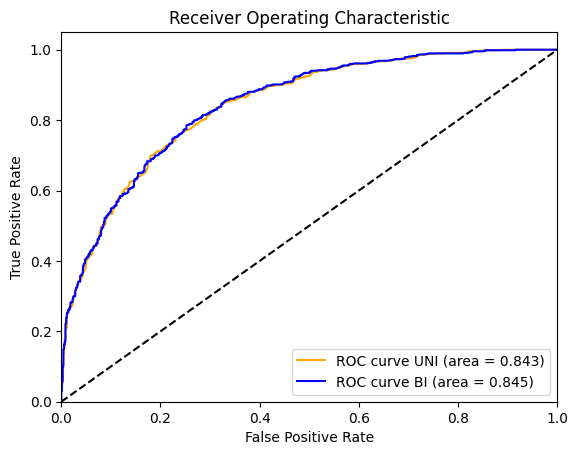

In [118]:
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for the positive class
y_pred_prob_uni = gnbBest.predict_proba(X_test[['Shell_weight']].values)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr_uni, tpr_uni, thresholds_uni = roc_curve(y_test, y_pred_prob_uni) 

# Compute the area under the ROC curve
roc_auc_uni = auc(fpr_uni, tpr_uni)


# Fit the model on the training data
gnbBi = gnbCustom.fit(X_train[['Shell_weight','Height']].values, y_train)

# Get the predicted probabilities for the positive class
y_pred_prob_bi = gnbBi.predict_proba(X_test[['Shell_weight','Height']].values)[:, 1]

# Compute the false positive rate, true positive rate, and thresholds
fpr_bi, tpr_bi, thresholds_bi = roc_curve(y_test, y_pred_prob_bi)

# Compute the area under the ROC curve
roc_auc_bi = auc(fpr_bi, tpr_bi)

# Plot the ROC curve
plt.plot(fpr_uni, tpr_uni, label='ROC curve UNI (area = %0.3f)' % roc_auc_uni, color='orange')
plt.plot(fpr_bi, tpr_bi, label='ROC curve BI (area = %0.3f)' % roc_auc_bi, color='blue')
plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Los modelos son extremadamente parecidos en rendimiento pero el bivariado es ligeramente mejor.

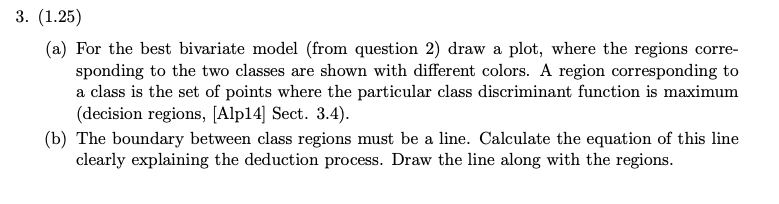

# 3. b) Buscamos el conjunto de puntos en el espacio característico tal que $P(C=1|\vec{x}) =  P(C=0|\vec{x}) \implies \frac{P(C=1|\vec{x})}{P(C=0|\vec{x})}= 1$ #
# Ahora $P(C=j|\vec{x}) = \frac{p(\vec{x}|C=j)P(C=j)}{p(\vec{x})}$. Si reemplazamos esto en la condición anterior obtenemos $\frac{p(\vec{x}|C=1)P(C=1)}{p(\vec{x}|C=0)P(C=0)}= 1$. #
# Por otro lado $ p(\vec{x}|C=j) \propto \exp(-(\vec{x}-\mu_j)^T \Sigma^{-1} (\vec{x}-\mu_j)) $. # 
# Luego, teniendo en cuenta la simetría de $\Sigma$: $\frac{p(\vec{x}|C=1)}{p(\vec{x}|C=0)} = \exp(-(\vec{x}-\mu_1)^T \Sigma^{-1} (\vec{x}-\mu_1))+(\vec{x}-\mu_0)^T \Sigma^{-1} (\vec{x}-\mu_0))$ 
# $\qquad \qquad =\exp(2\mu_1^T\Sigma^{-1}\vec{x}-\mu_1^T\Sigma^{-1}\mu_1 -2\mu_0^T\Sigma^{-1}\vec{x}+\mu_0^T\Sigma^{-1}\mu_0 )$ #
# $\qquad \qquad =\exp(2(\mu_1-\mu_0)^T\Sigma^{-1}\vec{x}-\mu_1^T\Sigma^{-1}\mu_1 +\mu_0^T\Sigma^{-1}\mu_0 )$ #
# Es decir que $ 2(\mu_1-\mu_0)^T\Sigma^{-1}\vec{x} = \mu_1^T\Sigma^{-1}\mu_1 -\mu_0^T\Sigma^{-1}\mu_0 +\log(\frac{P(C=0)}{P(C=1)}) .$
# Esta ecuación describe un hiperplano en el espacio de $\vec{x}$, en este caso una recta. #
# Para la ecuación de la recta en forma pendiente-intercepto, sea $\vec{v}$ el vector que multiplica a $\vec{x} $ y sea $K$ la constante del lado derecho de la ecuación, así #
# $\vec{v}^T\vec{x} = K$ # 
# La pendiente de la recta es entonces $-v_2/v_1$ y el intercepto es $K/v_2$.

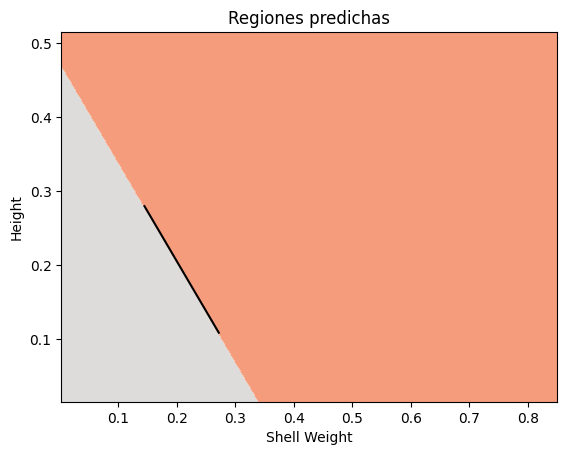

In [11]:
n = 350  # Número de puntos para la cuadrícula

# Rangos de 'shell weight' y 'height'
sw_max = np.max(X_test[['Shell_weight']].values)
sw_min = np.min(X_test[['Shell_weight']].values)
h_max = np.max(X_test[['Height']].values)
h_min = np.min(X_test[['Height']].values)

# Generar los valores de la cuadrícula con la misma cantidad de puntos (n)
x_vals = np.linspace(sw_min, sw_max, n)
y_vals = np.linspace(h_min, h_max, n)

# Crear la cuadrícula con los valores generados
xx, yy = np.meshgrid(x_vals, y_vals)

# Adaptar la forma de los datos para pasarlo a gnbBi.predict()
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Predecir las clases para cada punto en la cuadrícula
Z = gnbBi.predict(grid_points)

# Remodelar Z para que coincida con la forma de la cuadrícula xx
Z = Z.reshape(xx.shape)
# Medias de cada variable para cada clase
means = gnbBi.theta_

mu0 = means[0]
mu1 = means[1]

# Matriz de covarianza
sig = gnbBi.var_[0]
sig1 = np.linalg.inv(np.diag(sig))
#vector v descrito arriba
v = 2*(mu1-mu0)@sig1
#
P0 = np.sum(y_train == 0)
P1 = np.sum(y_train == 1)
#constante K
K = mu1@sig1@mu1.T-mu0@sig1@mu0.T-np.log(P0/P1)
#pendiente
m = -v[0]/v[1]
#intercepto
b = K/v[1]
x = np.linspace(0.145,0.272,20)
y = m * x + b

# Graficar el mapa de contorno
plt.contourf(xx, yy, Z, 30, cmap=plt.cm.coolwarm, vmin=-2, vmax=2)
plt.plot(x, y,'k')
plt.xlabel('Shell Weight')
plt.ylabel('Height')
plt.title('Regiones predichas')
plt.show()



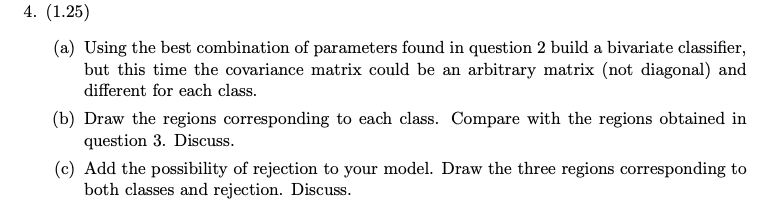

# 4. a)

In [141]:
from sklearn.utils.multiclass import _check_partial_fit_first_call
class GaussianNBFullCov(GaussianNB):
    def _update_mean_variance(self,n_past, mu, var, X, sample_weight=None):
               
        if X.shape[0] == 0:
            return mu, var

        # Compute (potentially weighted) mean and variance of new datapoints
        if sample_weight is not None:
            n_new = float(sample_weight.sum())
            if np.isclose(n_new, 0.0):
                return mu, var
            new_mu = np.average(X, axis=0, weights=sample_weight)
            new_var = np.average((X - new_mu) ** 2, axis=0, weights=sample_weight)
        else:
            n_new = X.shape[0]
            new_cov = np.cov(X, rowvar=False)
            new_mu = np.mean(X, axis=0)

        if n_past == 0:
            return new_mu, new_cov

        n_total = float(n_past + n_new)

        # Combine mean of old and new data, taking into consideration
        # (weighted) number of observations
        total_mu = (n_new * new_mu + n_past * mu) / n_total

        # Combine variance of old and new data, taking into consideration
        # (weighted) number of observations. This is achieved by combining
        # the sum-of-squared-differences (ssd)
        old_ssd = n_past * var
        new_ssd = n_new * new_cov
        total_ssd = old_ssd + new_ssd + (n_new * n_past / n_total) * np.prod((mu - new_mu))
        total_cov = total_ssd / n_total

        return total_mu, total_cov
    def _partial_fit(self, X, y, classes=None, _refit=False, sample_weight=None):
        first_call = _check_partial_fit_first_call(self, classes)
        if first_call:
            n_features = X.shape[1]
            n_classes = len(self.classes_)
            self.theta_ = np.zeros((n_classes, n_features))
            self.var_ = np.zeros((n_classes, n_features,n_features))
            self.class_count_ = np.zeros(n_classes, dtype=np.float64)
        super()._partial_fit(X, y, classes)

        return self
    def _joint_log_likelihood(self, X):
        joint_log_likelihood = []
        for i in range(np.size(self.classes_)):
            jointi = np.log(self.class_prior_[i])
            n_ij = -0.5*np.sum(np.log((2.0 * np.pi) * np.linalg.det(self.var_[i, :])))
            # Calculate the difference between X and self.theta_[i, :]
            diff = X - self.theta_[i, :]

            # Calculate the inverse of the variance matrix
            inv_var = np.linalg.inv(self.var_[i, :])
            matrix = np.tile(inv_var, (X.shape[0], 1, 1))

            # Perform the element-wise multiplication
            #(samples, features)*(samples, features, features) -> (samples, features)
            element_wise_result = np.einsum('ik,ijk->ij', diff, matrix)*diff

            # Sum the result to get the final output
            output = np.sum(element_wise_result, axis=1)
            n_ij-=0.5*output
            joint_log_likelihood.append(jointi + n_ij)

        joint_log_likelihood = np.array(joint_log_likelihood).T
        return joint_log_likelihood

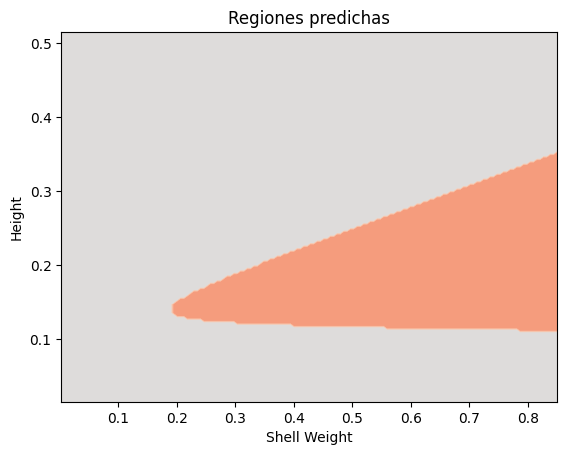

In [142]:
n = 150  # Número de puntos para la cuadrícula

# Rangos de 'shell weight' y 'height'
sw_max = np.max(X_test[['Shell_weight']].values)
sw_min = np.min(X_test[['Shell_weight']].values)
h_max = np.max(X_test[['Height']].values)
h_min = np.min(X_test[['Height']].values)

# Generar los valores de la cuadrícula con la misma cantidad de puntos (n)
x_vals = np.linspace(sw_min, sw_max, n)
y_vals = np.linspace(h_min, h_max, n)

# Crear la cuadrícula con los valores generados
xx, yy = np.meshgrid(x_vals, y_vals)

# Adaptar la forma de los datos para pasarlo a gnbBi.predict()
grid_points = np.c_[xx.ravel(), yy.ravel()]

gnb_full_cov = GaussianNBFullCov(var_smoothing=1e-9)
gnb_full_cov.fit(X_train[['Shell_weight','Height']].values, y_train)
Z = gnb_full_cov.predict(grid_points)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, 30, cmap=plt.cm.coolwarm, vmin=-2, vmax=2)
plt.xlabel('Shell Weight')
plt.ylabel('Height')
plt.title('Regiones predichas')
plt.show()



# Ahora, como regiones de decisión, vemos secciones cónicas, lo que es de esperar, ya que, al hacer un análisis similar al que hicimos en el punto 3. b), el término cuadrático en $\vec{x}$ no se cancela si las matrices de covarianza para cada clase son diferentes. #

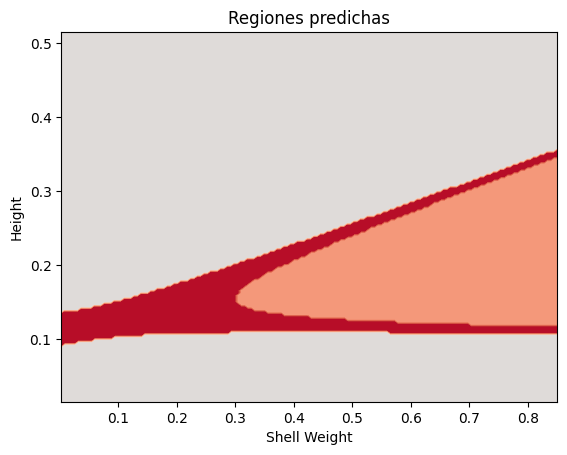

In [125]:
#costo esperado de rechazo 
lamb = 0.2
#clasificador (binario) con posibilidad de rechazo
def predR(clasificador,lamb,X):
    res = []
    #clase predicha por clasificador sin rechazo
    clase = clasificador.predict(X)
    #todas las probabilidades de ambas clases
    probas = clasificador.predict_proba(X)
    i = 0
    for p in probas:
        pmax = np.max(p)
        if 1-pmax < lamb:
            res.append(clase[i])
        else:
            res.append(2)
        i += 1
    return np.array(res)
Z = predR(gnb_full_cov,lamb,grid_points)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, 30, cmap=plt.cm.coolwarm, vmin=-2, vmax=2)
plt.xlabel('Shell Weight')
plt.ylabel('Height')
plt.title('Regiones predichas')
plt.show()


# 4. c) Como uno esperaría intuitivamente, se ve que la región de rechazo está más o menos donde estaba la frontera entre las regiones predichas por el clasificador sin posibilidad de rechazo, es decir la posibilidad de rechazo de alguna forma amplía la frontera entre las clases, la vueve una región de dos dimensiones, pues sin rechazo teníamos una curva (de una sola dimesión). # 